---


_The work here is mainly based on this Microsoft Reactor learning module (https://github.com/microsoft/Reactors/tree/master/Data_Science_2/Full_Day) and modified by Johnny King Lau (https://github.com/jonkingseestheworld/python_ml_trials)_


---

# Azure Cloud-based machine learning example

To run this notebook locally, the `azureml` package has to be installed. Or, as an 'easier' way to deploy without any installation on our own device, we can use the web-based Azure Notebooks (and by default the `azureml` package is installed), so we don't have to worry about that. 

> <font color=red>**Note:**</font> Looks like the `azureml` package previously works only with Python 2. If Python 2 has been installed, this can be changed in the menu at the top of the notebook (by clicking **Kernel > Change kernel > Python 2**).


## Create and connect to an Azure ML Studio workspace
`azureml` uses an Azure ML Studio workspace ID and authorization token to connect the notebook to the workspace; we can obtain the ID and token by following these steps:

1. Open [Azure ML Studio](https://studio.azureml.net) in a new browser tab and sign in with a Microsoft account. Azure ML Studio is free and does not require an Azure subscription. Once signed in with our Microsoft account (the same credentials we can use for Azure Notebooks), we are in our “workspace.”

2. On the left pane, click **Settings**.

    ![Settings button](https://github.com/microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-settings.png?raw=true)<br/><br/>

3. On the **Name** tab, the **Workspace ID** field contains our workspace ID. Copy that ID into the `workspace_id` value in the code cell in Step 5 of the notebook below.

    ![Location of workspace ID](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-workspace-id.png?raw=true)<br/><br/>

4. Click the **Authorization Tokens** tab, and then copy either token into the `authorization_token` value in the code cell in Step 5 of the notebook.

    ![Location of authorization token](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-tokens.png?raw=true)<br/><br/>

5. Run the code cell below; if it runs without error, we're ready to continue.

In [2]:
from azureml import Workspace

# Replace the values with those from our own Azure ML Studio instance; see Prerequisites
# The workspace_id is a string of hexadecimal characters; the token is a long string of random characters.
workspace_id = 'REPLACE WITH OUR ID'
authorization_token = 'REPLACE WITH OUR AUTHORIZATION TOKEN'

ws = Workspace(workspace_id, authorization_token)

## Explore Pima Indians Diabetes data

This is a dataset originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.

> **Reference**: https://www.kaggle.com/uciml/pima-indians-diabetes-database
**Acknowledege**: Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press. 

The dataset contains the following features:

- **`Pregnancies`**: Number of times pregnant
- **`Glucose`**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- **`BloodPressure`**: Diastolic blood pressure (mm Hg)
- **`SkinThickness`**: Triceps skin fold thickness (mm)
- **`Insulin`**: 2-Hour serum insulin (mu U/ml)
- **`BMI`**: Body mass index (weight in kg/(height in m)^2)
- **`DiabetesPedigreeFunction`**: Diabetes pedigree function 
- **`Age`**: Age (years)
- **`Outcome`**: Target (dependent) variable (0 or 1); 268 of 768 are 1, the others are 0; (1 = diabetes, 0 = no diabetes)

First, load the dataset and try to understand the data with the help of some plots.

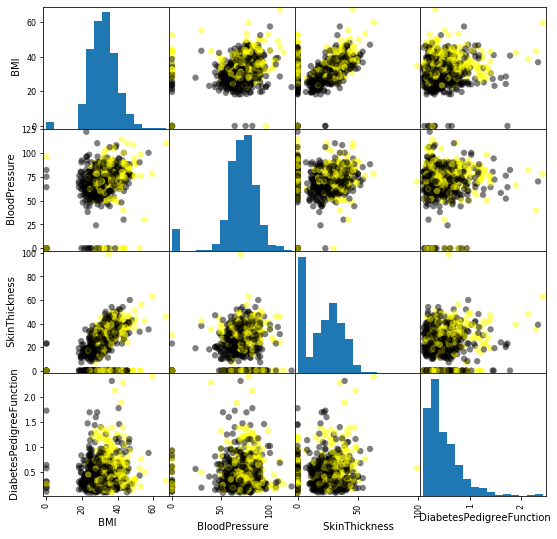

In [9]:
import pandas as pd
from pandas.plotting import scatter_matrix

#read  in the data as a dataframe
df1 = pd.DataFrame(pd.read_csv('data/pima-indians-diabetes.csv'))


from matplotlib import cm
%matplotlib inline

X = df1[[' BMI', ' BloodPressure', ' SkinThickness', ' DiabetesPedigreeFunction']] 
y = df1[' Outcome']

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, c= y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap=cmap)




For example, intuitively, it seems BMI and DiaetesPedigreeFunction are good predictors to separate the two types of Outcome (clusters of black and yellow dots)

## Transfer data to Azure ML Studio

We have our data, and the next step is to get them into Azure ML Studio in order to use them. That is where the `azureml` package comes in. It enables us to load data and models into Azure ML Studio from an Azure Notebook (or any Python environment).

The first code cell of this notebook is what establishes the connection with *our* Azure ML Studio accounts.

Now that we have our notebook talking to Azure ML Studio, we can export our data to it:

In [11]:
from azureml import DataTypeIds

dataset = ws.datasets.add_from_dataframe(
              dataframe=df1,
              data_type_id=DataTypeIds.GenericCSV,
              name='Pima Indian Diabetes Data',
              description='some example data'
          )

After running the code above, we will see the dataset listed in the **Datasets** section of the Azure Machine Learning Studio workspace. (**Note**: We might need to switch between browser tabs and refresh the page in order to see the dataset.)

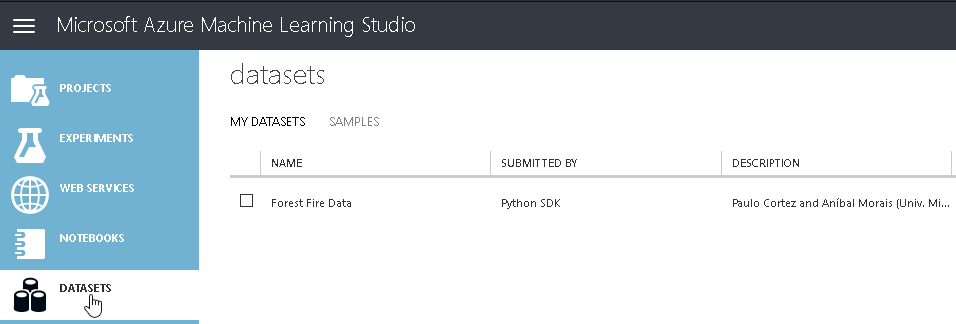<br/>

It is also straightforward to list the datasets available in the workspace and transfer datasets from the workspace to the notebook:

In [12]:
print('\n'.join([i.name for i in ws.datasets if not i.is_example])) # only list user-created datasets



Forest Fire Data
Pima Indian Diabetes Data


The dataset can be examined and interacted with in Azure ML Studio directly from this notebook:

In [13]:
# Read some more of the metadata
ds = ws.datasets['Pima Indian Diabetes Data']
print(ds.name)
print(ds.description)
print(ds.family_id)
print(ds.data_type_id)
print(ds.created_date)
print(ds.size)

# Read the contents
df2 = ds.to_dataframe()
df2.head()

Pima Indian Diabetes Data
some example data
b2683c9efa834f6b8ec0d294a485252f
GenericCSV
2020-01-14 14:17:43.101000
25860


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Create a simple model

Prepping data for the model and fitting the model. We can use the scikit-learn `train_test_split()` function with a slight change of parameters to select 75 percent of the data points for training and 25 percent for validation (testing).


The dataset has nine columns; we can use any of the eight features to try and predict the ninth column, Outcome (1 = diabetes, 0 = no diabetes).

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        df2[['Pregnancies','BloodPressure','SkinThickness','BMI','DiabetesPedigreeFunction','Age']],
        df2['Outcome'],
        test_size=0.25,
        random_state=42
    )

Rather than select all of the variables for the model, I was more selective and just chose **Pregnancies, BloodPressure, SkinThickness, BMI, DiabetesPedigreeFunction, Age** in order to predict Diabetes outcome.

Fit scikit-learn's `DecisionTreeRegressor` model using the training data. This algorithm is a combination of the linear regression and decision tree classification that you worked with in Section 6.

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_test_predictions = regressor.predict(X_test)
print('R^2 for true vs. predicted test set Diabetes Outcome: {:0.3f}'.format(r2_score(y_test, y_test_predictions)))

R^2 for true vs. predicted test set Diabetes Outcome: -0.968


## Deploy our model as a web service

This is the important part. Once deployed as a web service, our model can be accessed from anywhere. This means that rather than refit a model every time we need a new prediction for a business or humanitarian use case, we can send the data to the pre-fitted model and get back a prediction.

First, deploy the model as a predictive web service. To do so, create a wrapper function that takes input data as an argument and calls `predict()` with we trained model and this input data, returning the results.

In [31]:
from azureml import services

@services.publish(workspace_id, authorization_token)
@services.types(Pregnancies=float, BloodPressure=float,SkinThickness=float,BMI=float,DiabetesPedigreeFunction=float,Age=int)
@services.returns(float)

# The name of our web service is set to this function's name
def diabetes_predictor(Pregnancies,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age):
    return regressor.predict([Pregnancies,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age])

# Hold onto information about our web service so 
# we can call it within the notebook later
service_url = diabetes_predictor.service.url 
api_key = diabetes_predictor.service.api_key
help_url = diabetes_predictor.service.help_url
service_id = diabetes_predictor.service.service_id

#print(service_url, api_key, help_url, service_id)

We can also go to the **Web Services** section of our Azure ML Studio workspace to see the predictive web service running there.

## Consuming the web service

Next, consume the web service. To see if this works, try it here from the notebook session in which the web service was created. Just call the predictor directly:

In [32]:
#Provide in order the following information to predict the outcome:
#Pregnancies=float, 
#BloodPressure=float,
#SkinThickness=float,
#BMI=float,
#DiabetesPedigreeFunction=float,
#Age=int
diabetes_predictor.service(5.4, 0.2, 9, 22.1,22,23)

0